<a href="https://colab.research.google.com/github/dewhitee/system-modelling/blob/main/system_modelling_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [131]:
# Time distribution functions
def erlang(lam, s):
    return np.random.exponential(1. / lam, size=s) \
           + np.random.exponential(1. / lam, size=s) \
           + np.random.exponential(1. / lam, size=s)

def exponential(lam, s):
    return np.random.exponential(1. / lam, size=s)

arrival = [
    lambda: erlang(0.5, 1)[0],
    lambda: exponential(0.2, 1)[0]
]

departure = [
    lambda: np.random.normal(15, 2),
    lambda: np.random.exponential(3)
]

In [129]:
def start_simulation(overall_simulation_time=500.0):
    # Initials
    arrival_time = [arrival[0](),   # L1
                    arrival[1]()]   # L2
    departure_time = overall_simulation_time + 1    # 501

    delta_time = 0.0
    total_idle_time = min(arrival_time)

    total_event_count = 0
    total_departured_count = [0, 0]
    total_request_count = [0, 0]

    # 0 - server
    # 1..n - queue
    # server status: 0 - free, 1 - busy => len(queue) != 0
    queue = []

    # Stats for plot and summary
    times = []
    events = []
    l1_events = []
    l2_events = []

    # Print functions
    def print_delta_time():
        nonlocal delta_time
        return f'{round(delta_time, 2):<10}'

    def print_departure_time():
        nonlocal departure_time
        return f'{round(departure_time, 2):<17}'

    def get_percent(of, from_value):
        return of / from_value

    def get_queue_sliced():
        nonlocal queue
        return f'{queue[:10]} ... {queue[-10:]}' if len(queue) > 20 else queue

    # Request arrives
    def arrive():
        nonlocal delta_time, queue, departure_time, arrival_time

        # Get index of a nearest event time (type 1 or type 2)
        nearest_request_index = arrival_time.index(delta_time)

        # Updating nearest event's time
        arrival_time[nearest_request_index] = delta_time + arrival[nearest_request_index]()

        # If server is empty - calculating current request's departure time
        if len(queue) == 0:
            departure_time = delta_time + departure[nearest_request_index]()

        # Adding current request to server-queue
        queue.append(nearest_request_index)

        print(f'{"(ARRIVAL)":<12} ', f'{("(" + str(nearest_request_index) + ")"):<6}', 
              print_delta_time(),
              f'| {len(queue):<15} | {print_departure_time()} | q = {get_queue_sliced()}')

        # Increment total count stat for current request type
        total_request_count[nearest_request_index] += 1

    # Request departs, processing request
    def depart():
        nonlocal delta_time, queue, departure_time, total_departured_count, total_idle_time

        # Remove current request from the server - put next request from the queue in the server
        current_request = queue.pop(0)
        total_departured_count[current_request] += 1

        print(f'{"(DEPARTURE)":<12} ', f'{("(" + str(current_request) + ")"):<6}', print_delta_time(),
              f'| {len(queue):<15} | {"-":<17} | q = {get_queue_sliced()}')
        
         # Idle if queue is empty, otherwise update departure_time
        if len(queue) == 0:
            departure_time = float('inf')
            total_idle_time += min([min(arrival_time), overall_simulation_time]) - delta_time
            print(f'{"(IDLE)":<19} ', print_delta_time(), f': {0:<12}')
        else:
            departure_time = delta_time + departure[current_request]()

    def advance_in_time():
        nonlocal delta_time, queue, times, events, total_event_count

        # Updating the total (delta) time - choosing nearest request time
        delta_time = min([min(arrival_time), departure_time, overall_simulation_time])

        # Checking if we need to arrive or depart next (or none)
        if delta_time == min(arrival_time):
            arrive()
        elif delta_time == departure_time:
            depart()

        # Saving current data for stats
        times.append(delta_time)
        events.append(len(queue))
        l1_events.append(len([elem for elem in queue if elem == 0]))
        l2_events.append(len([elem for elem in queue if elem == 1]))
        total_event_count += 1

    print('Initial state:\n'
          f'queue: {queue}, status: {"empty" if len(queue) == 0 else "busy"}, '
          f'overall_simulation_time: {overall_simulation_time}, ' 
          f'arrival_time: [{arrival_time[0]:.2f}, {arrival_time[1]:.2f}], ' 
          f'departure_time: {departure_time:.2f}\n'
          f'\nTable notes:\n\tRequest of type L1 = 0, Request of type L2 = 1'
          f'\n\t*Items in system* column shows total number of requests, including one in the server'
          f'\n{"-" * 140}\n'
          f'{"Event":<10} | {"Class"} | {"Delta time"} | {"Items in system"} | {"Next departure at"} | q\n'
          f'{"(INITIAL)":<12} ', f'{(""):<6}', 
              print_delta_time(),
              f'| {len(queue):<15} | {print_departure_time()} | q = {get_queue_sliced()}')

    while delta_time < overall_simulation_time:
        advance_in_time()

    # Calculate idle coefficient
    print(f'{"-" * 140}')
    idle_coefficient = total_idle_time / overall_simulation_time
    total_departured = sum(total_departured_count)
    total_arrived = sum(total_request_count)

    unprocessed_requests_percent = get_percent(len(queue), len(total_request_count))

    active_time = overall_simulation_time - total_idle_time
    average_inqueue_time = active_time / total_departured
    average_request_count = sum(events) / len(events)
    l1_average_request_count = sum(l1_events) / len(l1_events)
    l2_average_request_count = sum(l2_events) / len(l2_events)

    l1_departured_percent = get_percent(total_departured_count[0], total_departured) * 100
    l2_departured_percent = get_percent(total_departured_count[1], total_departured) * 100
    l1_arrival_percent = get_percent(total_request_count[0], total_arrived) * 100
    l2_arrival_percent = get_percent(total_request_count[1], total_arrived) * 100

    print(f'SUMMARY:\n\t{"Server idle coefficient:":<40} {idle_coefficient:.4f}\n'
          f'\t{"Simulation time:":<40} {overall_simulation_time}\n'
          f'\t{"Max request count in queue:":40} {max(events)}\n'
          f'\nAVERAGE:\n\t{"Request time in the queue:":<40} {average_inqueue_time:.4f}\n'
          f'\t{"Count of requests in the queue:":<40} {average_request_count:.0f}\n'
          f'\t{"Count of type-1 requests in the queue:":<40} {l1_average_request_count:.0f}\n'
          f'\t{"Count of type-2 requests in the queue:":<40} {l2_average_request_count:.0f}\n'
          f'\nTOTAL:\n\t{"Server idle time:":<40} {total_idle_time:.4f}\n'
          f'\t{"Request count:":<40} {sum(total_request_count)}\n'
          f'\t{"Unprocessed requests count:":<40} {len(queue)}\n'
          f'\t{"Percent of unprocessed:":<40} {unprocessed_requests_percent:.2f}%\n'
          f'\nDEPARTURED:\n\t{"Departured requests:":<40} {total_departured}\n'
          f'\t{"Type-1 requests:":<40} {total_departured_count[0]}\n'
          f'\t{"Percent of type-1:":<40} {l1_departured_percent:.2f}%\n'
          f'\t{"Type-2 requests:":<40} {total_departured_count[1]}\n'
          f'\t{"Percent of type-2:":<40} {l2_departured_percent:.2f}%\n'
          f'\nARRIVED:\n\t{"Arrived requests:":<40} {sum(total_request_count)}\n'
          f'\t{"Type-1 requests:":<40} {total_request_count[0]}\n'
          f'\t{"Percent of type-1:":<40} {l1_arrival_percent:.2f}%\n'
          f'\t{"Type-2 requests:":<40} {total_request_count[1]}\n'
          f'\t{"Percent of type-2:":<40} {l2_arrival_percent:.2f}%\n')
    
    plt.plot(times, events, 'b')
    plt.xlabel("time")
    plt.ylabel("queue length")
    plt.grid()
    plt.title("Request queue length per time")
    plt.show()

Initial state:
queue: [], status: empty, overall_simulation_time: 500, arrival_time: [11.60, 5.79], departure_time: 501.00
Table note:
	Request of type L1 = 0, Request of type L2 = 1;
	*Items in system* column shows total number of requests, including one in the server
--------------------------------------------------------------------------------------------------------------------------------------------
Event      | Class | Delta time | Items in system | Next departure at | q
(INITIAL)            0.0        | 0               | 501               | q = []
(ARRIVAL)     (1)    5.79       | 1               | 8.13              | q = [1]
(DEPARTURE)   (1)    8.13       | 0               | -                 | q = []
(IDLE)               8.13       : 0           
(ARRIVAL)     (0)    11.6       | 1               | 24.5              | q = [0]
(ARRIVAL)     (1)    12.17      | 2               | 24.5              | q = [0, 1]
(ARRIVAL)     (0)    15.55      | 3               | 24.5           

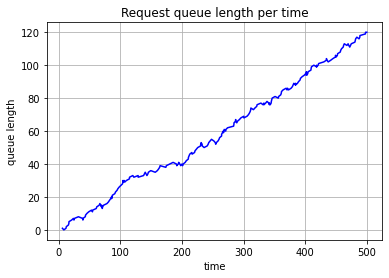

In [130]:
start_simulation(500)

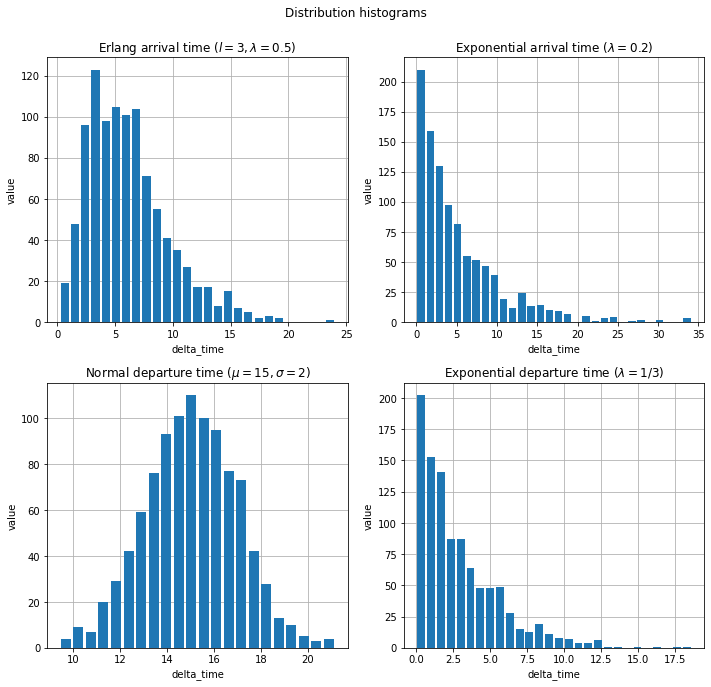

In [124]:
# Distribution histograms
plt.rc('axes', axisbelow=True) # push grid lines to background
plt.figure(figsize=(10, 10)) 

plt.subplot(2, 2, 1)
sample_erlang = erlang(0.5, 1000)
plt.title('Erlang arrival time ($l = 3, \lambda = 0.5$)')
plt.xlabel('delta_time')
plt.ylabel('value')
plt.grid()
plt.hist(sample_erlang, rwidth=0.8, bins='auto')

plt.subplot(2, 2, 2)
sample_exponential = exponential(0.2, 1000)
plt.title('Exponential arrival time ($\lambda = 0.2$)')
plt.xlabel('delta_time')
plt.ylabel('value')
plt.grid()
plt.hist(sample_exponential, rwidth=0.8, bins='auto')

plt.subplot(2, 2, 3)
sample_normal = np.random.normal(15, 2, 1000)
plt.title('Normal departure time ($\mu = 15, \sigma = 2$)')
plt.xlabel('delta_time')
plt.ylabel('value')
plt.grid()
plt.hist(sample_normal, rwidth=0.8, bins='auto')

plt.subplot(2, 2, 4)
sample_exponential2 = exponential(1./3, 1000)
plt.hist(sample_exponential2, rwidth=0.8, bins='auto')
plt.title('Exponential departure time ($\lambda = 1/3$)')
plt.xlabel('delta_time')
plt.ylabel('value')
plt.grid()
plt.suptitle("Distribution histograms")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()